In [2]:
import pandas as pd
import geopandas as gpd
import osmnx as osm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyproj import Transformer
from shapely.geometry import *
import networkx as nx

In [4]:
# import all the data
trip_data = pd.read_csv('../Data/02_Processed_Data/cleaned_trip_data.csv')
trip_data['Start date'] = pd.to_datetime(trip_data['Start date'])
trip_data['End date'] = pd.to_datetime(trip_data['End date'])
station_data = pd.read_csv('../Data/02_Processed_Data/Station_data_with_community.csv')
station_data = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data['lon'], station_data['lat'], crs='epsg:4326'))
station_data = osm.project_gdf(station_data)
central_london = osm.io.load_graphml('../Data/02_Processed_Data/Central_london.osm')

In [5]:
# add the longitude and latitude of the start and end stations
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='Start station', right_on='commonName', suffixes=('', '_start'))
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='End station', right_on='commonName', suffixes=('', '_end'))
# drop the commonName columns
trip_data.drop(columns=['commonName', 'commonName_end'], inplace=True)
# rename the lat and lon column to lat_start, lon_start
trip_data.rename(columns={'lat': 'lat_start', 'lon': 'lon_start'}, inplace=True)

In [6]:
# Get the CRS of the projected graph
crs_proj = central_london.graph['crs']

# Create a transformer to convert lat/lon to the projected CRS
transformer = Transformer.from_crs("epsg:4326", crs_proj, always_xy=True)

# 2) Data Exploration

In this Notebook we will explore the data that we cleaned in the previous notebook. 

We will look at the following:
1) Heatmap of the most frequently travelled streets
2) Heatmap of the most requently visited bicycle stations


## (01) Heatmap of the most frequently travelled streets

In [ ]:
num_od_pairs = 10

london_OD_paths_in_Network = trip_data.tail(num_od_pairs)

# Initialize the lists for 'od_paths_arc_infos' and 'od_paths'
q_list = []
n_list = []
a_list = []
d_list = []  # distance of an arc
counter = 0
# Iterate over the OD pairs
for index, row in london_OD_paths_in_Network.iterrows():
    print(f"Processing OD pair {counter}")
    # Find the nearest nodes in the graph to these points
    # Transform the coordinates to the projected CRS
    lon_proj, lat_proj = transformer.transform(row['lon_start'], row['lat_start'])
    lon_end_proj, lat_end_proj = transformer.transform(row['lon_end'], row['lat_end'])
    origin_node = osm.nearest_nodes(central_london,lon_proj, lat_proj)
    destination_node = osm.nearest_nodes(central_london, lon_end_proj, lat_end_proj)

    # Compute the shortest path
    try:
        path = osm.shortest_path(central_london, origin_node, destination_node, weight='length')
        print(path)
        arc_distances = []
        arcs = []

        if path is not None:
            # Calculate distances for each arc
            for i in range(len(path) - 1):
                arc = (path[i], path[i + 1])
                arcs.append(arc)
                distance = nx.shortest_path_length(central_london, arc[0], arc[1], weight="length")
                arc_distances.append(distance)

        q_list.append(index)
        n_list.append(path)
        a_list.append(arcs)
        d_list.append(arc_distances)
    except nx.NetworkXNoPath:
        print(f"No path found for OD pair at index {index}")
    
    counter += 1

# Create 'od_paths'
od_paths = pd.DataFrame({'q': q_list, 'N': n_list, 'A': a_list})

Processing OD pair 0
[[1448832904, 2451534389, 6812071067, 5473426058, 6029195278, 1448832908, 5467954319, 3598297082, 8979386429, 7706105487, 4837662845, 10857819472, 8979386424, 8977521475], [1448832904, 2451534389, 6812071067, 5473426058, 6029195278, 1448832908, 5467954319, 3598297082, 8979386429, 7706105487, 4837662845, 10857819472, 8979386424, 8977521475]]


NodeNotFound: Node [1448832904, 2451534389, 6812071067, 5473426058, 6029195278, 1448832908, 5467954319, 3598297082, 8979386429, 7706105487, 4837662845, 10857819472, 8979386424, 8977521475] not found in graph

NameError: name 'od_paths' is not defined

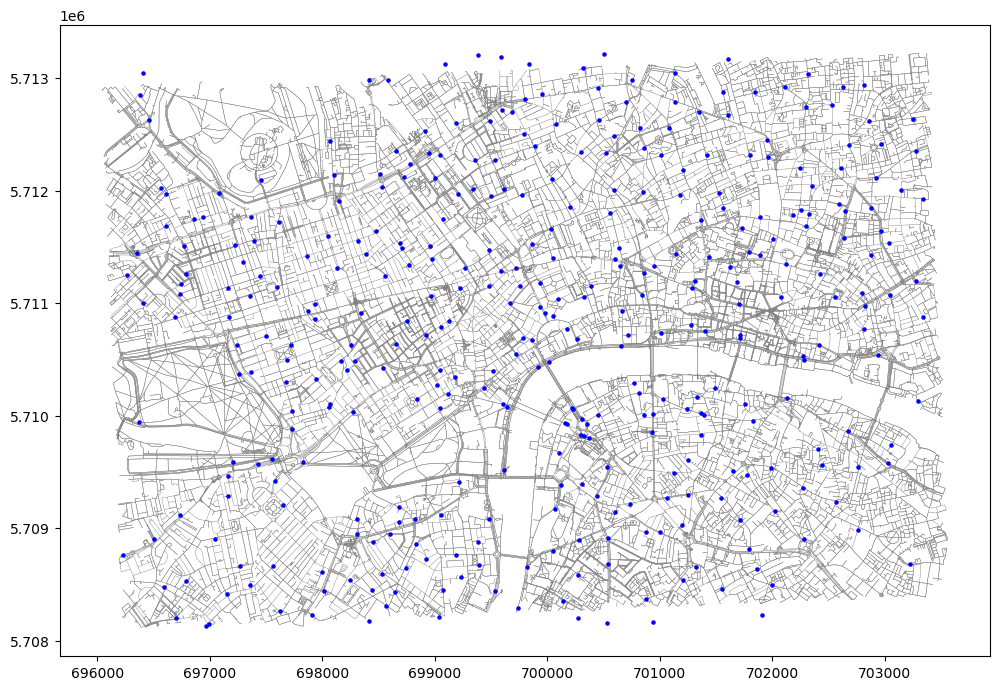

In [ ]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the street edges
edges = osm.graph_to_gdfs(central_london, nodes=False, edges=True)
edges.plot(ax=ax, linewidth=0.3, edgecolor='gray')

station_data.plot(ax=ax, color='b', markersize=5, zorder=2, label='Stations'), 

# Plot the paths

for path in od_paths['N']:
    if path:
        # Check if all nodes in path exist in the graph to avoid errors
        if all(node in central_london.nodes for node in path):
            # Get the x and y coordinates for each node in the path
            x_coords = [central_london.nodes[node]['x'] for node in path]
            y_coords = [central_london.nodes[node]['y'] for node in path]

            # Plot the path
            ax.plot(x_coords, y_coords, c='green', linewidth=2, zorder=3, alpha=0.1)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

## (02) Heatmap of the most requently visited bicycle stations

In [ ]:
# For every station, find the number of occurences in the trips dataframe, it can be as a start or end station
station_data['start_count'] = station_data['commonName'].map(trip_data['Start station'].value_counts())
station_data['end_count'] = station_data['commonName'].map(trip_data['End station'].value_counts()) 
station_data['count'] = station_data['start_count'] + station_data['end_count']
station_data = station_data.sort_values(by='count', ascending=False)
station_data


,commonName,lat,lon,NbDocks,geometry,start_count,end_count,count
118,"Waterloo Station 3, Waterloo",51.503791,-0.112824,35,POINT (700371.135 5709803.412),11583,12136,23719
257,"Waterloo Station 1, Waterloo",51.504027,-0.113864,36,POINT (700297.937 5709826.803),7174,6881,14055
11,"Argyle Street, Kings Cross",51.529416,-0.123944,45,POINT (699487.506 5712622.057),6404,6471,12875
157,"Wormwood Street, Liverpool Street",51.516154,-0.082422,16,POINT (702425.805 5711261.649),5888,5601,11489
140,"Hop Exchange, The Borough",51.504627,-0.091773,56,POINT (701828.105 5709954.226),3830,5110,8940
...,...,...,...,...,...,...,...,...
159,"Knightsbridge, Hyde Park",51.502757,-0.155349,43,POINT (697424.903 5709572.839),440,182,622
178,"Royal Avenue 1, Chelsea",51.489932,-0.162727,10,POINT (696968.252 5708127.038),270,292,562
366,"Upper Grosvenor Street, Mayfair",51.510130,-0.155757,18,POINT (697364.716 5710391.488),171,190,361
170,"Colombo Street, Southwark",51.505459,-0.105692,14,POINT (700858.665 5710008.421),173,157,330


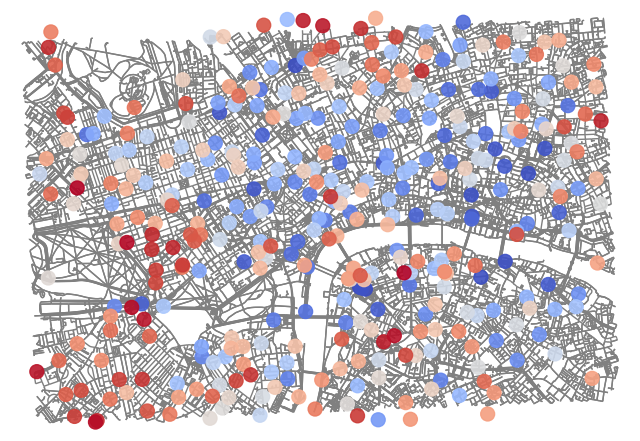

In [ ]:
# Plot the stations according to 'count' column, the more the count, the bigger the point
fig, ax = osm.plot_graph(central_london, node_size=3, bgcolor="none", edge_color="grey", node_color="none", show=False, close=False)

#bikestations.plot(ax=ax, markersize =bikestations['count'] / 10 , alpha=0.4, cmap='coolwarm')
station_data.plot(ax=ax, markersize=100 , alpha=0.9, cmap='coolwarm')
plt.axis('off')
plt.show()

## (03) Analze demand patterns

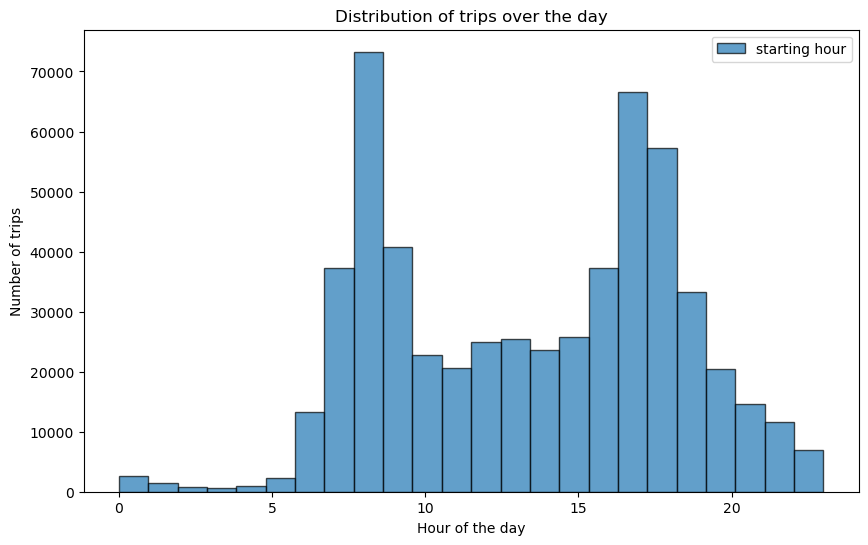

In [ ]:
trip_data['starting_hour'] = trip_data['Start date'].dt.hour
trip_data['ending_hour'] = trip_data['End date'].dt.hour

# visualize the distribution of trips over the day
plt.figure(figsize=(10, 6))
plt.hist(trip_data['starting_hour'], bins=24, alpha=0.7, edgecolor='black', label='starting hour')
#plt.hist(cleaned_trip_data['ending_hour'], bins=24, alpha=0.7, label='ending hour')
plt.xlabel('Hour of the day')
plt.ylabel('Number of trips')
plt.title('Distribution of trips over the day')
plt.legend()
plt.show()

## (04) Station Efficiency Analysis

## (05) Bicycle Stationarity Analysis

In [7]:
# Sort the data by bike number and start date
trip_data = trip_data.sort_values(['Bike number', 'Start date'])

# Rank the trips within each bike's history to index them
trip_data['start_date_index'] = trip_data.groupby('Bike number')['Start date'].rank(method='first').astype(int) - 1

# Get the previous trip's end date and station for each bike
trip_data['prev_end_date'] = trip_data.groupby('Bike number')['End date'].shift(1)
trip_data['prev_end_station'] = trip_data.groupby('Bike number')['End station'].shift(1)

# Handle cases where there is no previous trip by filling with the current start date and station
trip_data['prev_end_date'] = trip_data['prev_end_date'].fillna(trip_data['Start date'])
trip_data['prev_end_station'] = trip_data['prev_end_station'].fillna(trip_data['Start station'])

trip_data['time_between_trips'] = trip_data['Start date'] - trip_data['prev_end_date']
trip_data['time_between_trips'] = trip_data['time_between_trips'].dt.total_seconds() / 60
trip_data

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration (ms),...,lat_end,lon_end,lat_start,lon_start,lat_end,lon_end,start_date_index,prev_end_date,prev_end_station,time_between_trips
81051,137023110,2024-02-01 07:58:00,1011,"Argyle Street, Kings Cross",2024-02-01 08:12:00,300222,"Fore Street, Guildhall",2,CLASSIC,887136,...,51.518093,-0.091401,51.529416,-0.123944,51.518093,-0.091401,0,2024-02-01 07:58:00,"Argyle Street, Kings Cross",0.0
74159,137040501,2024-02-01 18:21:00,300222,"Fore Street, Guildhall",2024-02-01 18:23:00,1211,"Bunhill Row, Moorgate",2,CLASSIC,135523,...,51.520858,-0.089887,51.518093,-0.091401,51.520858,-0.089887,1,2024-02-01 08:12:00,"Fore Street, Guildhall",609.0
72399,137045119,2024-02-01 21:39:00,1211,"Bunhill Row, Moorgate",2024-02-01 21:46:00,2701,"Columbia Road, Shoreditch",2,CLASSIC,456037,...,51.528187,-0.075375,51.520858,-0.089887,51.528187,-0.075375,2,2024-02-01 18:23:00,"Bunhill Row, Moorgate",196.0
71045,137049280,2024-02-02 08:24:00,2701,"Columbia Road, Shoreditch",2024-02-02 08:28:00,1064,"Old Street Station, St. Luke's",2,CLASSIC,249190,...,51.525615,-0.088532,51.528187,-0.075375,51.525615,-0.088532,3,2024-02-01 21:46:00,"Columbia Road, Shoreditch",638.0
67845,137057909,2024-02-02 15:11:00,1064,"Old Street Station, St. Luke's",2024-02-02 15:16:00,979,"Wenlock Road , Hoxton",2,CLASSIC,295957,...,51.530991,-0.093903,51.525615,-0.088532,51.530991,-0.093903,4,2024-02-02 08:28:00,"Old Street Station, St. Luke's",403.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492715,138809216,2024-04-24 15:48:00,999,"Queen Street 1, Bank",2024-04-24 15:55:00,22171,"Red Lion Street, Holborn",61201,PBSC_EBIKE,429182,...,51.518240,-0.116550,51.511553,-0.092940,51.518240,-0.116550,66,2024-04-24 14:24:00,"Queen Street 1, Bank",84.0
490569,138814115,2024-04-24 18:01:00,22171,"Red Lion Street, Holborn",2024-04-24 18:13:00,1102,"Leman Street, Aldgate",61201,PBSC_EBIKE,705207,...,51.512363,-0.069542,51.518240,-0.116550,51.512363,-0.069542,67,2024-04-24 15:55:00,"Red Lion Street, Holborn",126.0
489920,138815803,2024-04-24 18:35:00,1102,"Leman Street, Aldgate",2024-04-24 18:38:00,1080,"Great Tower Street, Monument",61201,PBSC_EBIKE,216952,...,51.510484,-0.082989,51.512363,-0.069542,51.510484,-0.082989,68,2024-04-24 18:13:00,"Leman Street, Aldgate",22.0
475398,138854160,2024-04-26 11:44:00,1222,"Goswell Road (City Uni), Finsbury",2024-04-26 11:59:00,995,"Little Argyll Street, West End",61201,PBSC_EBIKE,901821,...,51.514499,-0.141423,51.528246,-0.101026,51.514499,-0.141423,69,2024-04-24 18:38:00,"Great Tower Street, Monument",2466.0


In [8]:
# Clean the data by removing the outliers from the time_between_trips column
time_between_trips = trip_data['time_between_trips']
Q1 = time_between_trips.quantile(0.25)
Q3 = time_between_trips.quantile(0.75)
IQR = Q3 - Q1
time_between_trips_cleaned = time_between_trips[(time_between_trips >= Q1 - 1.5 * IQR) & (time_between_trips <= Q3 + 1.5 * IQR)]


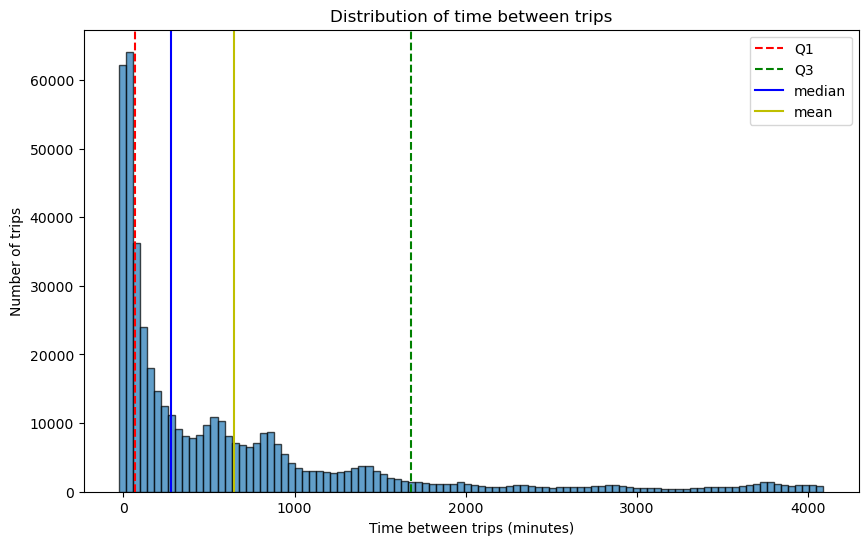

In [9]:
# Plot the distribution of the time between trips 
plt.figure(figsize=(10, 6))
plt.hist(time_between_trips_cleaned, bins=100, alpha=0.7, edgecolor='black')
# add vertical lines for Q1 and Q3 and display the values
plt.axvline(Q1, color='r', linestyle='--', label='Q1')
plt.axvline(Q3, color='g', linestyle='--', label='Q3')
# add a line for the median
plt.axvline(time_between_trips_cleaned.median(), color='b', linestyle='-', label='median')
# add a line for the average
plt.axvline(time_between_trips_cleaned.mean(), color='y', linestyle='-', label='mean')

plt.legend()
plt.xlabel('Time between trips (minutes)')
plt.ylabel('Number of trips')
plt.title('Distribution of time between trips')
plt.show()


In [10]:
print(time_between_trips_cleaned.std())

884.5896836875298
